In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression as LR
# 读取数据
train_df = pd.read_csv('../data/糖尿病遗传风险预测挑战赛公开数据/比赛训练集.csv', encoding='gbk')
test_df = pd.read_csv('../data/糖尿病遗传风险预测挑战赛公开数据/比赛测试集.csv', encoding='gbk')


# 基础特征工程
train_df['体重指数_round'] = train_df['体重指数'] // 10
test_df['体重指数_round'] = test_df['体重指数'] // 10

# train_df['舒张压指数_round'] = train_df['舒张压'] // 90 + 1
# test_df['舒张压数_round'] = test_df['舒张压'] // 90 + 1



train_df['口服耐糖量测试'] = train_df['口服耐糖量测试'].replace(-1, np.nan)
test_df['口服耐糖量测试'] = test_df['口服耐糖量测试'].replace(-1, np.nan)

dict_糖尿病家族史 = {
    '无记录': 0,
    '叔叔或姑姑有一方患有糖尿病': 1,
    '叔叔或者姑姑有一方患有糖尿病': 1,
    '父母有一方患有糖尿病': 2
}
train_df['口服耐糖量测试指数'] = train_df['口服耐糖量测试'] // 8.5

train_df['糖尿病家族史'] = train_df['糖尿病家族史'].map(dict_糖尿病家族史)
test_df['糖尿病家族史'] = test_df['糖尿病家族史'].map(dict_糖尿病家族史)

train_df['糖尿病家族史'] = train_df['糖尿病家族史'].astype('category')
test_df['糖尿病家族史'] = test_df['糖尿病家族史'].astype('category')

train_df['性别'] = train_df['性别'].astype('category')
test_df['性别'] = test_df['性别'].astype('category')

train_df['年龄'] = 2022 - train_df['出生年份']
test_df['年龄'] = 2022 - test_df['出生年份']

# train_df['年龄_round'] = train_df['年龄'] // 30 
# test_df['年龄_round'] = test_df['年龄'] // 30 


train_df['口服耐糖量测试_diff'] = train_df['口服耐糖量测试'] - train_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']
test_df['口服耐糖量测试_diff'] = test_df['口服耐糖量测试'] - test_df.groupby('糖尿病家族史').transform('mean')['口服耐糖量测试']
# 模型交叉验证
def run_model_cv(model, kf, X_tr, y, X_te, cate_col=None):
    train_pred = np.zeros( (len(X_tr), len(np.unique(y))) )
    test_pred = np.zeros( (len(X_te), len(np.unique(y))) )

    cv_clf = []
    for tr_idx, val_idx in kf.split(X_tr, y):
        x_tr = X_tr.iloc[tr_idx]; y_tr = y.iloc[tr_idx]

        x_val = X_tr.iloc[val_idx]; y_val = y.iloc[val_idx]

        call_back = [
            lgb.early_stopping(50),
        ]
        eval_set = [(x_val, y_val)]
        model.fit(x_tr, y_tr, eval_set=eval_set, callbacks=call_back, verbose=-1)

        cv_clf.append(model)

        train_pred[val_idx] = model.predict_proba(x_val)
        test_pred += model.predict_proba(X_te)

    test_pred /= kf.n_splits
    return train_pred, test_pred, cv_clf

clf = lgb.LGBMClassifier(
    max_depth=5, 
    n_estimators=4000, 
    n_jobs=-1, 
    verbose=-1,
    verbosity=-1,
    learning_rate=0.05,
)


train_pred, test_pred, cv_clf = run_model_cv(
    clf, KFold(n_splits=5),
    train_df.drop(['编号', '患有糖尿病标识'], axis=1),
    train_df['患有糖尿病标识'],
    test_df.drop(['编号'], axis=1),
)

print((train_pred.argmax(1) == train_df['患有糖尿病标识']).mean())


D:\anaconda\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
D:\anaconda\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\anaconda\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] verbosity is set=-1, verbose=-1 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[204]	valid_0's binary_logloss: 0.132594


ValueError: Number of features of the model must match the input. Model n_features_ is 11 and input n_features is 10

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['FangSong']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg') # 展示的图片格式

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3164\2943757456.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg') # 展示的图片格式


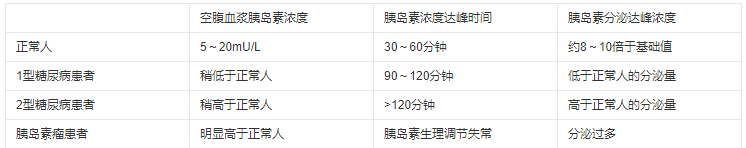


胰岛素释放实验：空腹时定量口服葡萄糖刺激胰岛β细胞释放胰岛素。比赛数据采用服糖后120分钟的血浆胰岛素水平，单位pmol/L；
根据《中国2型糖尿病防治指南（2017年版）》，糖尿病的诊断标准是具有典型糖尿病症状（烦渴多饮、多尿、多食、不明原因的体重下降）且随机静脉血浆葡萄糖≥11.1mmol/L或空腹静脉血浆葡萄糖≥7.0mmol/L或口服葡萄糖耐量试验（OGTT）负荷后2h血浆葡萄糖≥11.1mmol/L。
正常人的胰岛素分泌常与血糖值呈平行状态，在服糖后30—60分钟达到峰值，其浓度为空腹值的5—7倍，达到峰值后的胰岛素测定值较峰值应有一个明显的下降，180分钟的测定值应只比空腹值略高。

口服葡萄糖耐量试验
诊断糖尿病的一种实验室检查方法。比赛数据采用120分钟耐糖测试后的血糖值，单位mmol/L；
正常参考值范围编辑 
空腹血糖3.9～6.1mmol/L，血糖在口服葡萄糖0.5～1小时达高峰，峰值<8.99mmol/L，2小时内血糖<7.8mmol/L，3小时后血糖恢复正常。
目前国内常用的糖耐量试验及妊娠糖尿病的诊断标准为：
1. 空腹静脉血浆血糖≥6.1mmol/L。
2. 口服葡萄糖75g，1小时后≥10.0mmol/L。
3. 2小时≥8.5mmol/L。
4. 3小时≥8.0mmol/L。其中两项高就考虑糖尿病。
5. 正常范围：
空腹3.9-6.1mmol/L（70-110mg/dL）；
60分钟6.7-9.5mmol/L（120-170mg/dL）；
120分钟≤7.8mmol/L（≤140mg/dL）；
180分钟3.9-6.1mmol/L（70-110mg/dL）。
如何判定编辑 播报
1. 当静脉空腹血糖<6.1mmol/L，OGTT2小时血糖<7.8mmoI/L，说明人体对进食葡萄糖后的血糖调节能力正常，为正常人。
2. 当静脉空腹血糖≥7.0mmol/L或OGTT2小时血糖≥11.1mmoI/L，说明人体处理进食后葡萄糖的能力明显降低，可以确诊糖尿病。
3. 当静脉空腹血糖<7.0mmol/L，并且OGTT2小时血糖介于7.8-11.1mmoI/L之间，说明人体对葡萄糖的调节能力轻度下降，可以诊断糖耐量减低。
4. 当静脉空腹血糖介于6.1-7.0mmol/L之间，且OGTT2小时血糖≤7.8mmol/L，说明人体对进食葡萄糖后的血糖调节能力尚好，但对空腹血糖调节能力轻度减退，可以诊断空腹血糖受损。


肱三头肌皮褶厚度：在右上臂后面肩峰与鹰嘴连线的重点处，夹取与上肢长轴平行的皮褶，纵向测量，单位cm.

<AxesSubplot:xlabel='患有糖尿病标识', ylabel='胰岛素释放实验'>

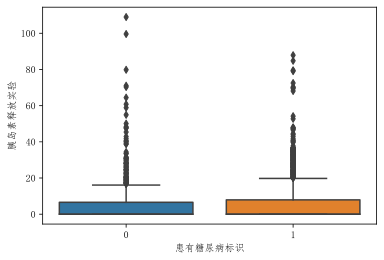

In [29]:
sns.boxplot(y='胰岛素释放实验', x='患有糖尿病标识', data=train_df)

<AxesSubplot:xlabel='胰岛素释放实验', ylabel='口服耐糖量测试'>

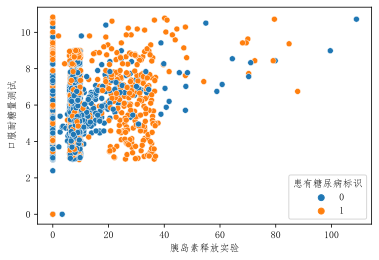

In [34]:
sns.scatterplot(y='口服耐糖量测试', x='胰岛素释放实验', hue='患有糖尿病标识',data=train_df)

<AxesSubplot:xlabel='患有糖尿病标识', ylabel='肱三头肌皮褶厚度'>

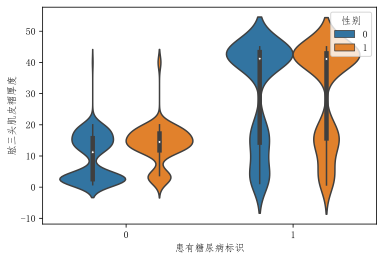

In [58]:
sns.violinplot(y='肱三头肌皮褶厚度', x='患有糖尿病标识', hue='性别', data=train_df[train_df.肱三头肌皮褶厚度 != 0])

可以看到患病与不患病得肱三头肌皮褶厚度差异很大，这也是一个很强的特征

In [56]:
train_df[(train_df.胰岛素释放实验>= 20) & (train_df.患有糖尿病标识 == 1)]

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识,体重指数_round,年龄,口服耐糖量测试_diff,肱三头肌皮褶厚度_指数
9,10,1,1997,44.9,0,89.0,4.699,32.97,0.00,1,4.0,25,-1.197475,0.0
95,96,1,1977,29.2,0,96.0,7.732,70.30,2.35,1,2.0,45,1.835525,235.0
100,101,0,1988,47.4,0,99.0,6.986,27.48,12.60,1,4.0,34,1.089525,1260.0
126,127,1,1978,25.5,0,89.0,6.266,35.43,0.00,1,2.0,44,0.369525,0.0
160,161,1,1983,36.5,1,72.0,10.182,44.52,3.82,1,3.0,39,4.214788,382.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4922,4923,0,2000,41.1,1,74.0,7.350,36.61,4.12,1,4.0,22,1.382788,412.0
4931,4932,1,1991,33.0,2,76.0,8.271,25.04,3.33,1,3.0,31,2.145048,333.0
4991,4992,1,1980,57.5,2,89.0,4.584,20.75,16.20,1,5.0,42,-1.541952,1620.0
5059,5060,0,1993,42.1,2,76.0,6.968,26.65,3.63,1,4.0,29,0.842048,363.0


In [57]:
train_df[(train_df.胰岛素释放实验 >= 20) & (train_df.患有糖尿病标识 == 0)].count()

编号              65
性别              65
出生年份            65
体重指数            65
糖尿病家族史          65
舒张压             61
口服耐糖量测试         62
胰岛素释放实验         65
肱三头肌皮褶厚度        65
患有糖尿病标识         65
体重指数_round      65
年龄              65
口服耐糖量测试_diff    62
肱三头肌皮褶厚度_指数     65
dtype: int64

### 特征筛选 ###
口服耐糖量测试 >= 8.5 mmol/L是一个很强的特征，这是通过查资料得到的，代入数据患病与不患病的比率是411：41（10：1）
###    ####
根据可视化图标得到，胰岛素释放实验 > 20 mmol/L是一个较强的特称，代入数据得238：65（4：1）

In [62]:
train_df['口服耐糖量测试指数'] = train_df['口服耐糖量测试'] // 8.5

In [63]:
train_df

,编号,性别,出生年份,体重指数,糖尿病家族史,舒张压,口服耐糖量测试,胰岛素释放实验,肱三头肌皮褶厚度,患有糖尿病标识,体重指数_round,年龄,口服耐糖量测试指数,口服耐糖量测试_diff
0,1,0,1996,30.1,0,106.0,3.818,7.89,0.0,0,3.0,26,0.0,-2.078475
1,2,0,1988,27.5,0,84.0,NaN,0.00,14.7,0,2.0,34,NaN,NaN
2,3,1,1988,36.5,0,85.0,7.131,0.00,40.1,1,3.0,34,0.0,1.234525
3,4,1,1992,29.5,0,91.0,7.041,0.00,0.0,0,2.0,30,0.0,1.144525
4,5,0,1998,42.0,1,NaN,7.134,0.00,0.0,1,4.0,24,0.0,1.166788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,5066,1,1992,36.4,2,95.0,3.102,0.00,0.0,0,3.0,30,0.0,-3.023952
5066,5067,1,1991,37.1,1,94.0,6.207,6.77,0.0,0,3.0,31,0.0,0.239788
5067,5068,0,1975,25.4,0,90.0,7.343,0.00,0.0,0,2.0,47,0.0,1.446525
5068,5069,0,1972,28.5,2,101.0,6.268,8.99,0.0,0,2.0,50,0.0,0.142048
